In [2]:
!pip install nlp
!pip install tensorflow==2.3.0
!pip install seaborn
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.8 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1)
ERROR: No matching distribution found for tensorflow==2.3.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.6 MB/s eta 0:00:00


**importation des librairies**

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import nlp

pd.set_option('display.max_colwidth', None)

sns.set(style="whitegrid", font_scale=1.4)

%load_ext autoreload
%autoreload 2

assert tf.__version__ >= "2.0"

In [4]:
train_ds, val_ds, test_ds = nlp.load_dataset(
    'allocine',
    split=['train', 'validation', 'test']
)

Downloading:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.81k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/66.6M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset allocine_dataset downloaded and prepared to /root/.cache/huggingface/datasets/allocine_dataset/allocine/1.0.0/aa139a1ef73f1658a0e987a110e98c11f0205d876ae764503881bdad8fe4f425. Subsequent calls will reuse this data.


In [5]:
type(train_ds)

nlp.arrow_dataset.Dataset

In [6]:
train_ds

Dataset(features: {'review': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['neg', 'pos'], names_file=None, id=None)}, num_rows: 160000)

In [7]:
train_ds["review"][0]

'Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 mouvement

In [8]:
train_ds["label"][0]

0

**Traitement des données**

In [9]:
MAX_NB_WORDS = 20000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=MAX_NB_WORDS,
    lower=True,
    oov_token="<unk>"
)

tokenizer.fit_on_texts(train_ds['review'])

word_index = tokenizer.word_index
vocab_size = len(word_index)
print("Nombre de tokens uniques : {}".format(vocab_size))

Nombre de tokens uniques : 186308


In [10]:
train_reviews_tokenized = tokenizer.texts_to_sequences(train_ds["review"])
val_reviews_tokenized = tokenizer.texts_to_sequences(val_ds["review"])
test_reviews_tokenized = tokenizer.texts_to_sequences(test_ds["review"])

In [11]:
first_review = train_reviews_tokenized[0]
first_review[:15]

[45, 68, 4664, 17, 77, 15081, 7, 80, 9, 8746, 2505, 249, 439, 17, 1181]

In [12]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
" ".join([index_to_word[i] for i in first_review[:15]])

"si vous cherchez du cinéma abrutissant à tous les étages n'ayant aucune peur du cliché"

**Affichage de la distribution des longueurs de phrases**

longueur moyenne: 91.5
longueur maximale: 389


<ipython-input-13-90765865ea70>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(reviews_len, bins=150, kde=False, hist_kws=dict(alpha=0.8))


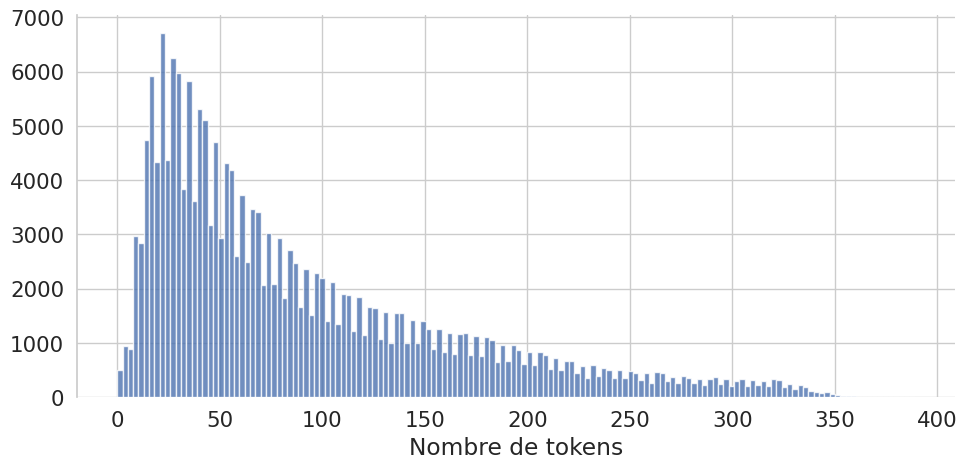

In [13]:
reviews_len = [len(s) for s in train_reviews_tokenized + val_reviews_tokenized + test_reviews_tokenized]
print("longueur moyenne: {:.1f}".format(np.mean(reviews_len)))
print("longueur maximale: {}".format(np.max(reviews_len)))

plt.figure(figsize=(10, 5))
ax = sns.distplot(reviews_len, bins=150, kde=False, hist_kws=dict(alpha=0.8))
ax.set(xlabel='Nombre de tokens')

# finaliser le graphe
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

**Suppression des séquences vides**

In [14]:
def remove_empty_sequences(reviews, labels):
    reviews_not_empty = []
    labels_not_empty = []
    removed = 0
    for x, y in zip(reviews, labels):
        if len(x) > 0:
            reviews_not_empty.append(x)
            labels_not_empty.append(y)
        else:
            removed += 1
    return reviews_not_empty, labels_not_empty

In [15]:
print("Suppression de {} sequences vides".format(reviews_len.count(0)))

train_reviews_tokenized, train_labels = remove_empty_sequences(
    train_reviews_tokenized,
    train_ds["label"]
)

test_reviews_tokenized, test_labels = remove_empty_sequences(
    test_reviews_tokenized,
    test_ds["label"]
)

val_reviews_tokenized, val_labels = remove_empty_sequences(
    val_reviews_tokenized,
    val_ds["label"]
)

# verification

reviews_len = [len(s) for s in train_reviews_tokenized + val_reviews_tokenized + test_reviews_tokenized]
assert(reviews_len.count(0)==0)

Suppression de 8 sequences vides


**Padding**

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LENGTH_SEQ = 350

X_train = pad_sequences(
    train_reviews_tokenized,
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_val = pad_sequences(
    val_reviews_tokenized,
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_test = pad_sequences(
    test_reviews_tokenized,
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

print('Dimension du tenseur X_train: ', X_train.shape)
print('Dimension du tenseur X_val: ', X_val.shape)
print('Dimension du tenseur X_test: ', X_test.shape)

Dimension du tenseur X_train:  (159993, 350)
Dimension du tenseur X_val:  (19999, 350)
Dimension du tenseur X_test:  (20000, 350)


**Transformations des libellés en numpy Array**

In [17]:
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

**Utilisation de la couche d'intégration**

In [18]:
embedding_layer = layers.Embedding(1000, 5)

In [19]:
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()

array([[-0.01690941,  0.03543487, -0.00862899,  0.03133723, -0.03774891],
       [-0.03177496,  0.02766642, -0.02261082, -0.01813885, -0.03229892],
       [ 0.0141287 , -0.04428375,  0.04510534,  0.00756714, -0.01630654]],
      dtype=float32)

In [21]:
result = embedding_layer(tf.constant([[0, 1, 2], [3, 4, 5]]))
result.shape

TensorShape([2, 3, 5])

**Création du modèle de Machine Learning**

In [22]:
def create_model(embedding_dim=16, vocab_size=vocab_size):
  model = keras.Sequential([
      layers.Embedding(vocab_size, embedding_dim),
      layers.GlobalAveragePooling1D(),
      layers.Dense(embedding_dim, activation='relu'),
      layers.Dense(1)
  ])
  return model

In [23]:
model = create_model()

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          2980928   
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2981217 (11.37 MB)
Trainable params: 2981217 (11.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Entrainement du modèle**

In [24]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=4,
    batch_size=120,
    validation_steps=8
)

Epoch 1/4
1334/1334 [==============================] - 107s 79ms/step - loss: 0.4052 - accuracy: 0.7771 - val_loss: 0.2321 - val_accuracy: 0.9167
Epoch 2/4
1334/1334 [==============================] - 100s 75ms/step - loss: 0.2068 - accuracy: 0.9174 - val_loss: 0.2202 - val_accuracy: 0.9333
Epoch 3/4
1334/1334 [==============================] - 101s 76ms/step - loss: 0.1765 - accuracy: 0.9301 - val_loss: 0.1973 - val_accuracy: 0.9333
Epoch 4/4
1334/1334 [==============================] - 94s 71ms/step - loss: 0.1613 - accuracy: 0.9366 - val_loss: 0.1868 - val_accuracy: 0.9292


In [25]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric], '')
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

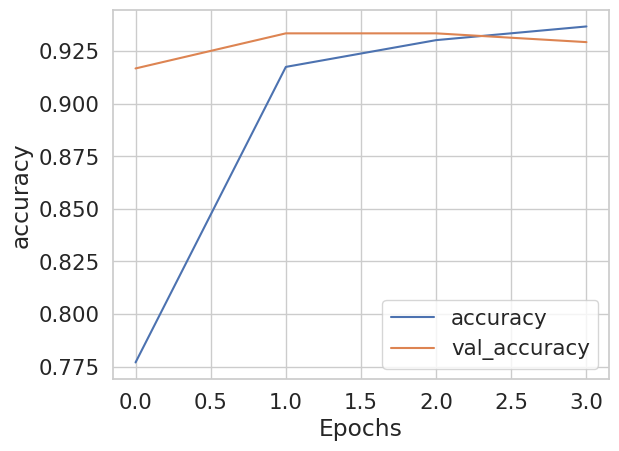

In [26]:
plot_graphs(history, 'accuracy')

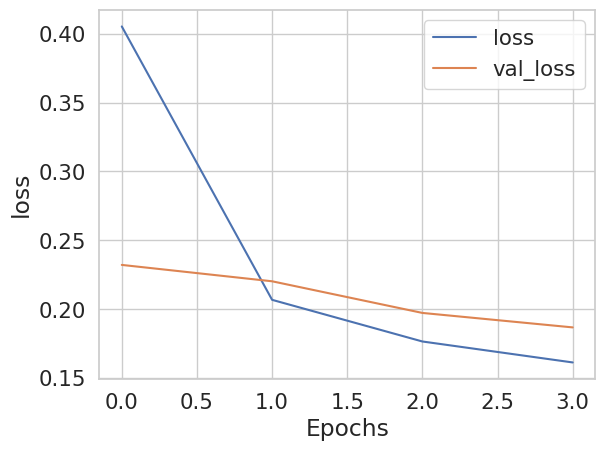

In [27]:
plot_graphs(history, 'loss')

In [28]:
model.evaluate(X_test, y_test, verbose=False)

[0.19114021956920624, 0.9242500066757202]

**Récupération des intégrations apprises**

In [29]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(186308, 16)


In [30]:
import io

out_v = io.open('verctors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadatas.tsv', 'w', encoding='utf-8')

for num, word in enumerate(tokenizer.word_index):
    vec = weights[num]
    out_m.write(word + "\n")
    out_v.write('/t'.join([str(x) for x in vec]) + 'n')

out_v.close()
out_m.close()

In [31]:
def sample_predict(text):

    def prob(logit):
        return 1/(1 + np.exp(-logit))

    text_tokenized = tokenizer.texts_to_sequences(text)
    text_tokenized = [i[0] for i in text_tokenized if i != []]
    text_tokenized = np.array(text_tokenized)
    text_tokenized = text_tokenized[:MAX_LENGTH_SEQ]

    while len(text_tokenized) < MAX_LENGTH_SEQ:
             text_tokenized = np.append(text_tokenized, 0)

    text_tokenized = tf.expand_dims(text_tokenized, 0)
    prediction = model.predict(text_tokenized)

    return prob(prediction)

In [32]:
text = "Je deteste perdre mon temps a regarder ce film"
sample_predict(text)

1/1 [==============================] - 0s 106ms/step


array([[0.74288785]], dtype=float32)

**Test du modèle**

In [34]:
import os
model.save("model_allocine")
print(os.listdir('model_allocine'))

['assets', 'fingerprint.pb', 'saved_model.pb', 'keras_metadata.pb', 'variables']


In [35]:
model = tf.keras.models.load_model('model_allocine')
print(model.evaluate(X_test, y_test, verbose=False))

[0.19114021956920624, 0.9242500066757202]
